### PyTorchのインポート

In [0]:
import torch

In [0]:
from torch.autograd import Variable#自動微分
import torch.nn as nn#ネットワーク定義
import torch.optim as optim
import torch.nn.functional as F

In [0]:
import torch.utils.data
import torchvision
from torchvision import datasets, models, transforms

#### その他ライブラリ

In [0]:
  import numpy as np
  import math
  from matplotlib import pyplot as plt

### データセット作成

#### サイン関数を作る

In [0]:
class DataMaker(object):
  
    def __init__(self, steps_per_cycle, number_of_cycles):
        self.steps_per_cycle = steps_per_cycle
        self.number_of_cycles = number_of_cycles
 
    def make(self):#もともと実装されていたもの。使わない
        return np.array([math.sin(i * 2 * math.pi/self.steps_per_cycle) for i in range(self.steps_per_cycle)] * self.number_of_cycles)
    
    def make_int(self, max):#SNNには整数で入力値を表したほうがわかりやすいためこっちでデータを作る
        sin_base = np.array([math.sin(i * 2 * math.pi/self.steps_per_cycle) for i in range(self.steps_per_cycle)] * self.number_of_cycles)
        sin_int = np.array(list(map(int, sin_base*(max/2)))) + int(max/2)
        return sin_int
      
    def make_x(self):#グラフプロット用x軸のデータ
        x = np.linspace(0, self.number_of_cycles * 2 * np.pi, self.steps_per_cycle * self.number_of_cycles)#グラフプロット用x軸
        return x
 
    def make_mini_batch(self, data, mini_batch_size, length_of_sequence):
        sequences = np.ndarray((mini_batch_size, length_of_sequence), dtype=np.float32)#mini_batch_size行length_of_sequence列の配列を生成
        for i in range(mini_batch_size):
            index = random.randint(0, len(data) - length_of_sequence)
            sequences[i] = data[index:index+length_of_sequence]
        return sequences

In [0]:
base = DataMaker(50, 2)
sin_int = base.make_int(128)
x = base.make_x()

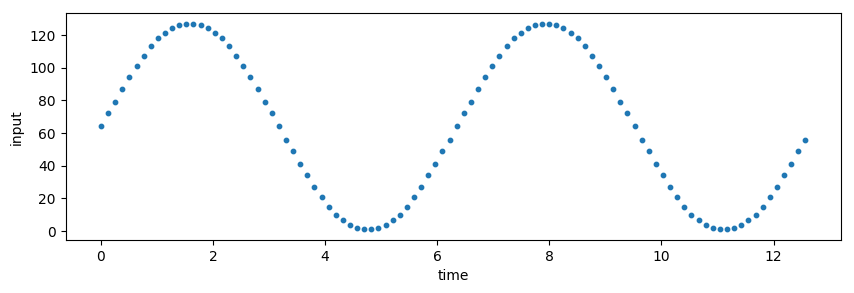

In [7]:
fig = plt.figure(figsize=(10,3), dpi=100, facecolor='w')
ax1 = fig.add_subplot(1,1,1)
plt.xlabel("time")
plt.ylabel("input")
ax1.scatter(x, sin_int, s=10)
plt.show()

#### 入力値は(t-2, t-1, t)の3ch。教師値は次時刻の予測値なので1ch

In [0]:
def input_target(input_n, split_n):
  input_sin = []
  target_sin = []
  for i in range(input_n.size - split_n):
    input_sin.append(input_n[i : i+split_n])
    target_sin.append(input_n[i+split_n])
    
  return np.array(input_sin), np.array(target_sin)

In [0]:
sin_input, sin_target = input_target(sin_int, 3)

#### 入力と教師値をタプルにする

In [0]:
sin_input_torch = torch.tensor(sin_input)
sin_target_torch = torch.tensor(sin_target)

In [0]:
dataset = torch.utils.data.TensorDataset(sin_input_torch, sin_target_torch)

#### ミニバッチに分割

In [0]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)

## SNNモデル構築